# Early Prediction of Sepsis Using ICU Time-Series Data
## Exploratory Data Analysis (EDA)

**Dataset:** PhysioNet / Computing in Cardiology Challenge 2019  
**Prediction Task:** Predict onset of sepsis within the next 6 hours  
**Unit of analysis:** Hourly ICU time steps per patient

### Objectives of this notebook
- Understand the structure and format of the raw ICU time-series data
- Examine feature groups (vitals, labs, demographics, outcome)
- Analyse missingness patterns and temporal coverage
- Inspect the distribution and behaviour of the `SepsisLabel`
- Identify challenges relevant for preprocessing and modelling

### Key EDA Questions

1. How many patient ICU stays are available in the dataset?
2. What is the typical length of an ICU time series?
3. How prevalent is sepsis at the time-step and patient level?
4. How severe is missingness across vital signs and laboratory variables?
5. Are there observable temporal patterns prior to sepsis onset?


In [2]:
# Core Python utilities
from pathlib import Path
import os

# Numerical and data handling
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings for clarity
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

# Set a clean plotting style
sns.set(style="whitegrid")

### Raw Data Directory

The raw PhysioNet 2019 challenge data is stored in `data/raw/`.
The dataset consists of multiple files, where each file corresponds
to a single ICU patient stay with hourly time-series observations.

At this stage, we only inspect the directory structure and load
individual patient files for exploratory purposes.

In [3]:
# Paths
DATA_DIR = Path("../data/raw")
DATA_FILE = DATA_DIR / "Dataset.csv"

# Sanity check
print("Dataset.csv exists:", DATA_FILE.exists())
print("Dataset.csv path:", DATA_FILE.resolve())

# Load
df = pd.read_csv(DATA_FILE)

# Basic inspection
print("\nShape (rows, columns):", df.shape)
print("\nColumn names:")
print(df.columns.tolist())

print("\nPreview (first 5 rows):")
display(df.head())

print("\nData types summary:")
display(df.dtypes.value_counts())

print("\nMissing values (top 15 columns by missing count):")
missing_counts = df.isna().sum().sort_values(ascending=False)
display(missing_counts.head(15))


Dataset.csv exists: True
Dataset.csv path: C:\Users\Nikhitha\OneDrive\Desktop\EarlySepsisPrediction\data\raw\Dataset.csv

Shape (rows, columns): (1552210, 44)

Column names:
['Unnamed: 0', 'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID']

Preview (first 5 rows):


,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,26.0,0.4,NaN,NaN,NaN,NaN,23.0,NaN,9.6,104.0,0.8,NaN,161.0,NaN,1.6,2.1,3.2,NaN,NaN,29.7,9.5,30.6,11.3,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072



Data types summary:


float64    38
int64       6
Name: count, dtype: int64


Missing values (top 15 columns by missing count):


Bilirubin_direct    1549220
Fibrinogen          1541968
TroponinI           1537429
Bilirubin_total     1529069
Alkalinephos        1527269
AST                 1527027
Lactate             1510764
PTT                 1506511
SaO2                1498649
EtCO2               1494574
Phosphate           1489909
HCO3                1487182
Chloride            1481744
BaseExcess          1468065
PaCO2               1465909
dtype: int64

Identifying Key Columns

In [4]:
# Identify key columns
patient_id_col = "Patient_ID"
time_col = "ICULOS"
target_col = "SepsisLabel"

print("Patient ID column:", patient_id_col)
print("Time column:", time_col)
print("Target column:", target_col)

# Basic sanity checks
print("\nUnique patients:", df[patient_id_col].nunique())
print("Min ICULOS:", df[time_col].min())
print("Max ICULOS:", df[time_col].max())

print("\nTarget value counts (time-step level):")
print(df[target_col].value_counts())

Patient ID column: Patient_ID
Time column: ICULOS
Target column: SepsisLabel

Unique patients: 40336
Min ICULOS: 1
Max ICULOS: 336

Target value counts (time-step level):
SepsisLabel
0    1524294
1      27916
Name: count, dtype: int64


Sepsis Prevalence

In [5]:
# Time-step level prevalence
timestep_prevalence = df[target_col].mean()

# Patient-level prevalence (did the patient ever have SepsisLabel = 1?)
patient_prevalence = (
    df.groupby(patient_id_col)[target_col]
      .max()
      .mean()
)

print(f"Time-step level sepsis prevalence: {timestep_prevalence:.4f}")
print(f"Patient-level sepsis prevalence: {patient_prevalence:.4f}")

Time-step level sepsis prevalence: 0.0180
Patient-level sepsis prevalence: 0.0727


ICU length-of-stay distribution

In [6]:
# ICU length of stay per patient
icu_los = (
    df.groupby(patient_id_col)[time_col]
      .max()
)

print("ICU length-of-stay summary (hours):")
display(icu_los.describe())

ICU length-of-stay summary (hours):


count    40336.000000
mean        39.010115
std         22.924641
min          8.000000
25%         24.000000
50%         39.000000
75%         47.000000
max        336.000000
Name: ICULOS, dtype: float64

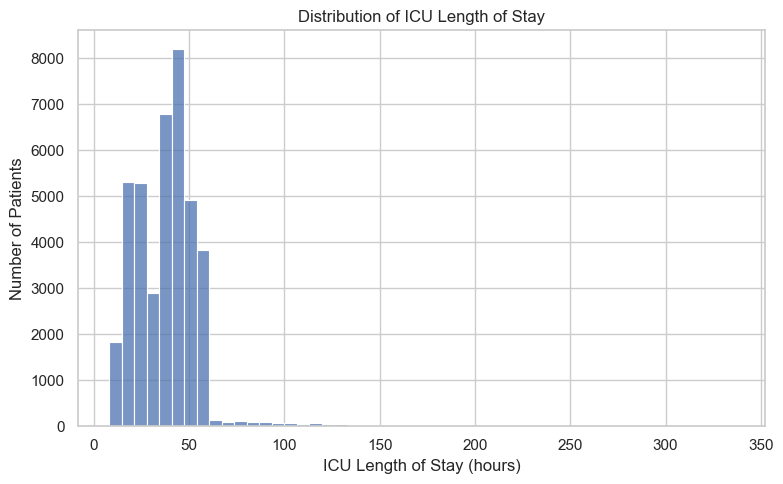

In [7]:
# Plot ICU length-of-stay distribution
plt.figure(figsize=(8, 5))
sns.histplot(icu_los, bins=50, kde=False)

plt.xlabel("ICU Length of Stay (hours)")
plt.ylabel("Number of Patients")
plt.title("Distribution of ICU Length of Stay")

plt.tight_layout()
plt.show()

Sepsis Label Imbalance

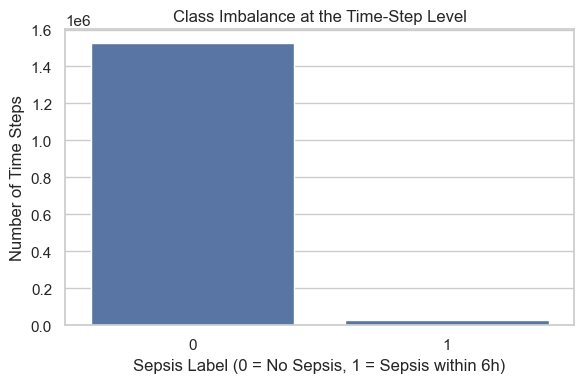

In [8]:
# Plot class imbalance at the time-step level
plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df)

plt.xlabel("Sepsis Label (0 = No Sepsis, 1 = Sepsis within 6h)") 
plt.ylabel("Number of Time Steps")
plt.title("Class Imbalance at the Time-Step Level")

plt.tight_layout()
plt.show()

Missingness Heatmap

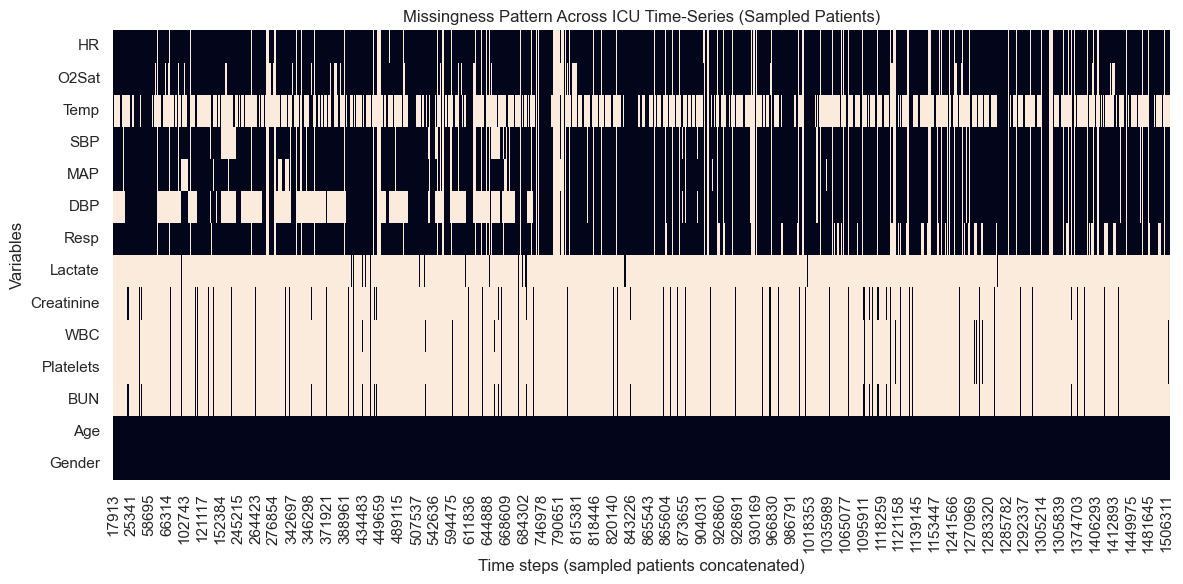

In [9]:
# Select a random subset of patients for visualisation
np.random.seed(42)
sample_patients = np.random.choice(
    df[patient_id_col].unique(),
    size=100,
    replace=False
)

df_sample = df[df[patient_id_col].isin(sample_patients)]

# Select a subset of clinically relevant variables for clarity
feature_cols = [
    "HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp",  # vitals
    "Lactate", "Creatinine", "WBC", "Platelets", "BUN", # labs
    "Age", "Gender"
]

missing_matrix = df_sample[feature_cols].isna()

plt.figure(figsize=(12, 6))
sns.heatmap(
    missing_matrix.T,
    cbar=False,
    yticklabels=feature_cols
)

plt.xlabel("Time steps (sampled patients concatenated)")
plt.ylabel("Variables")
plt.title("Missingness Pattern Across ICU Time-Series (Sampled Patients)")

plt.tight_layout()
plt.show()

Selected patient: 9


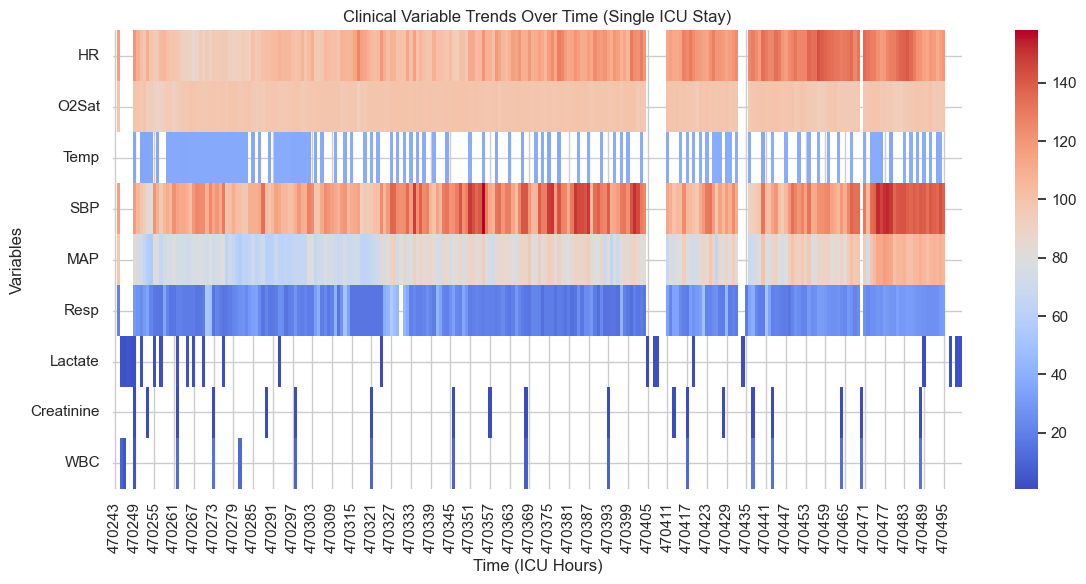

In [10]:
# ----- Value Heatmap for a Single Patient -----

# Select one patient (first patient with sepsis if possible)
sepsis_patients = df.groupby(patient_id_col)[target_col].max()
sepsis_patient_ids = sepsis_patients[sepsis_patients == 1].index

if len(sepsis_patient_ids) > 0:
    selected_patient = sepsis_patient_ids[0]
else:
    selected_patient = df[patient_id_col].iloc[0]

print("Selected patient:", selected_patient)

patient_df = df[df[patient_id_col] == selected_patient].sort_values(time_col)

# Select important clinical variables
heatmap_vars = [
    "HR", "O2Sat", "Temp", "SBP", "MAP", "Resp",
    "Lactate", "Creatinine", "WBC"
]

# Subset and transpose for heatmap
patient_data = patient_df[heatmap_vars]

plt.figure(figsize=(12, 6))
sns.heatmap(
    patient_data.T,
    cmap="coolwarm",
    cbar=True
)

plt.xlabel("Time (ICU Hours)")
plt.ylabel("Variables")
plt.title("Clinical Variable Trends Over Time (Single ICU Stay)")

plt.tight_layout()
plt.show()

## Exploratory Data Analysis Summary

The PhysioNet 2019 ICU dataset contains 40,336 unique ICU patient stays and over 1.5 million hourly observations. The prediction task is defined at the time-step level, where the objective is to predict the onset of sepsis within the next six hours.

### Class Imbalance
Sepsis is highly imbalanced at the time-step level, with approximately 1.8% of hourly observations labelled positive. However, at the patient level, approximately 7.3% of patients develop sepsis at some point during their ICU stay. This imbalance motivates the use of evaluation metrics such as AUROC and AUPRC rather than accuracy.

### ICU Length of Stay
ICU length of stay is right-skewed, with a median of approximately 39 hours and a long tail extending beyond 300 hours. This variability highlights the need for modelling approaches that can handle variable-length time series.

### Missingness Patterns
Vital signs are measured frequently with relatively low missingness, whereas laboratory variables are highly sparse and measured intermittently in blocks. Missingness appears structured rather than random, reflecting real-world clinical measurement practices. This motivates feature-specific preprocessing strategies.

### Temporal Dynamics
Visualisation of individual patient trajectories demonstrates dynamic changes in physiological variables over time, supporting the use of temporal modelling approaches such as LSTM or GRU architectures.

Overall, the dataset exhibits high dimensionality, severe class imbalance, variable sequence lengths, and structured missingness. These characteristics directly inform the preprocessing strategy and model selection in subsequent stages of the project.